In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from pathlib import Path
from pprint import pprint
from copy import deepcopy
import operator

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import (
    StandardScaler,
    PolynomialFeatures,
)
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyRegressor

import seaborn as sns
from tqdm.notebook import tqdm

import itertools
import functools

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, max_error

In [3]:
import equadratures as eq

In [4]:
df_zenith = pd.read_csv(
    "data/Z6_Dataframe_zenith.csv", parse_dates=True, dayfirst=True
)
df_direct = pd.read_csv(
    "data/Z6_Dataframe_direct.csv", parse_dates=True, dayfirst=True
)

In [5]:
# If the dates have not been parsed for some reason, they will have obj type instead of datetime type.
# This check is probably not necessary anymore, it was put in when we were debugging an issue with the dates.
# There is no harm in leaving it in.
if df_zenith.dt.dtype == "O":
    df_zenith["dt"] = pd.to_datetime(df_zenith.dt, dayfirst=True)

if df_direct.dt.dtype == "O":
    df_direct["dt"] = pd.to_datetime(df_direct.dt, dayfirst=True)

In [6]:
# The constants file was reformatted a bit from the file originally provided to me,
# but this should be consistent with what you have.
if Path("data/Z6_Dataframe_constants.csv").is_file():
    df_constants = pd.read_csv("data/Z6_Dataframe_constants.csv")
else:
    df_constants = pd.read_excel("data/Z6_Dataframe.xlsx", sheet_name=4)
    df_constants.to_csv("data/Z6_Dataframe_constants.csv")
droplist = []
for col in df_constants.columns:
    if "Unnamed:" in col:
        droplist.append(col)

df_constants = df_constants.drop(droplist, axis=1)
df_constants

,Year,Lo (A),Lo (C),Lo (D),Lat,Long,ID
0,2011,-0.030,-0.010,-0.010,-75.61,-26.21,031E
1,2012,-0.020,-0.010,-0.010,-75.61,-26.21,031E
2,2013,-0.020,-0.010,-0.010,-75.61,-26.22,031E
3,2014,-0.020,-0.010,-0.010,-75.61,-26.24,031E
4,2015,-0.020,-0.010,-0.010,-75.61,-26.25,031E
5,2016,-0.025,-0.010,-0.010,-75.61,-26.27,031E
6,2017,-0.022,-0.013,-0.011,-75.57,-25.47,031E
7,2018,-0.030,-0.020,-0.025,-75.57,-25.47,031E
8,2019,-0.040,-0.030,-0.030,-75.57,-25.49,031E
9,2017,-0.025,-0.016,-0.013,NaN,NaN,073E


In [7]:
# Remove annoying whitespace from column names. Tends to happen with excel files.
df_zenith = df_zenith.rename(columns=lambda x: x.strip())
df_direct = df_direct.rename(columns=lambda x: x.strip())
df_constants = df_constants.rename(columns=lambda x: x.strip())

In [8]:
# Back up the uncalibrated values.
# We will overwrite with L0 subtracted values.
for band in ["A", "C", "D"]:
    df_zenith[f"L({band})_uncalib"] = df_zenith[f"L({band})"]

In [9]:
# Apply the S calibration
for [Dobson, year], df in df_zenith.assign(year=df_zenith.dt.dt.year).groupby(
    ["Dobson", "year"]
):
    print(Dobson, year)
    for band in ["A", "C", "D"]:
        constant = df_constants[
            (df_constants.ID == Dobson) & (df_constants.Year == year)
        ][f"Lo ({band})"]
        try:
            constant = constant.item()
        except:
            print("\t", band, "\tNo calib constant for this year/band")
            constant = 0
        print("\t", band, "\t", constant)
        df_zenith.loc[df.index, f"L({band})"] = (
            df_zenith.loc[df.index, f"L({band})_uncalib"] + constant
        )

031E 2012
	 A 	 -0.02
	 C 	 -0.01
	 D 	 -0.01
031E 2013
	 A 	 -0.02
	 C 	 -0.01
	 D 	 -0.01
031E 2014
	 A 	 -0.02
	 C 	 -0.01
	 D 	 -0.01
031E 2015
	 A 	 -0.02
	 C 	 -0.01
	 D 	 -0.01
031E 2016
	 A 	 -0.025
	 C 	 -0.01
	 D 	 -0.01
031E 2017
	 A 	 -0.022
	 C 	 -0.013
	 D 	 -0.011
031E 2018
	 A 	 -0.03
	 C 	 -0.02
	 D 	 -0.025
031E 2019
	 A 	 -0.04
	 C 	 -0.03
	 D 	 -0.03
031E 2020
	 A 	No calib constant for this year/band
	 A 	 0
	 C 	No calib constant for this year/band
	 C 	 0
	 D 	No calib constant for this year/band
	 D 	 0
073E 2017
	 A 	 -0.025
	 C 	 -0.016
	 D 	 -0.013
073E 2018
	 A 	 -0.18
	 C 	 -0.11
	 D 	 -0.055
073E 2019
	 A 	 -0.18
	 C 	 -0.11
	 D 	 -0.055
073E 2020
	 A 	 -0.18
	 C 	 -0.11
	 D 	 -0.055


In [10]:
def get_mu(zenith):

    """
    Calculate mu value, using station and sun information.

    More or less copypasted from https://gitlab.data.bas.ac.uk/joson/autodobson/-/blob/master/autodobson/station.py
    """

    earth_radius = 6378137
    r = 6
    SZA = np.deg2rad(zenith)
    lat = -75.57
    rho = 0.9983271 + 1.6764e-3 * np.cos(2 * lat) * 35e-6 * np.cos(4 * lat)
    R = rho * earth_radius
    h = 26000 - (abs(lat) * 100)
    mu = (R + h) / np.sqrt(np.square(R + h) - np.square(R + r) * np.square(np.sin(SZA)))
    return mu

In [11]:
# Parse clearsky / cloudy flag
df_zenith["cloud"] = df_zenith.type.astype("str").str[-1]

# The cloud state is unknown for autodobson measurements
df_zenith.loc[df_zenith.Dobson == "073E", "cloud"] = "-1"

df_zenith["mu"] = get_mu(df_zenith.zenith_angle)

# Extra variables that I find useful
# Not all of these will end up being used in the final model.
assign_extras = lambda df: df.assign(
    cosSZA=np.cos(np.deg2rad(df.zenith_angle)),
    month=df.dt.dt.month,
    year=df.dt.dt.year,
    D073E=df.Dobson == "073E",  # onehot encoding of Dobson ID
    D031E=df.Dobson == "031E",  # onehot encoding of Dobson ID
    n1C_m_n2C=df["L1(C)"] - df["L2(C)"],
    n1D_m_n2D=df["L1(D)"] - df["L2(D)"],
    n1A_m_n2A=df["L1(A)"] - df["L2(A)"],
    nC_m_nD=(df["L(C)"] - df["L(D)"]),
    nA_m_nD=(df["L(A)"] - df["L(D)"]),
    nC_o_nD=(df["L(C)"] / df["L(D)"]),
    nA_o_nD=(df["L(A)"] / df["L(D)"]),
    secSZA=1 / np.cos(np.deg2rad(df.zenith_angle)),
    nA_m_nD_o_mu=(df["L(A)"] - df["L(D)"]) / df.mu,
    nC_m_nD_o_mu=(df["L(C)"] - df["L(D)"]) / df.mu,
    invmu=1 / df.mu,
)

df_direct = assign_extras(df_direct)
df_zenith = assign_extras(df_zenith)

In [12]:
# 073E has only a few measurements in 2017-2018, so I will throw them out.
# In the past, I've found that almost all these measurements were anomalous.
# It could just be that the calibration constants are a long way off.
df_zenith = df_zenith[(df_zenith.Dobson != "073E") | (df_zenith.year >= 2019)]

In [13]:
# There are some duplicated datetimes in the direct sun dataset.
# This causes problems when you try to associate zenith
# measurements with its nearest direct sun measurement.
df_direct.loc[df_direct.dt.duplicated()]

,Unnamed: 0,dt,type1,type2,Dobson,Lat,Lon,mu,zenith_angle,100hPa T,...,n1D_m_n2D,n1A_m_n2A,nC_m_nD,nA_m_nD,nC_o_nD,nA_o_nD,secSZA,nA_m_nD_o_mu,nC_m_nD_o_mu,invmu
2385,2385,2016-11-06 17:53:00,1,0,031E,-75.61,-26.2709,2.668,68.44,199.60330,...,-0.00738,-0.0046,NaN,0.73700,NaN,2.599809,2.721271,0.276237,NaN,0.374813
2594,2594,2017-01-27 13:41:00,1,0,031E,-75.61,-26.2709,1.839,57.34,229.72545,...,0.00000,0.0000,0.84499,0.75818,3.198777,2.972886,1.853044,0.412278,0.459483,0.543774


In [14]:
# As a result I drop duplicated datetimes in both datasets.
df_direct = df_direct.drop_duplicates("dt")
df_zenith = df_zenith.drop_duplicates("dt")

# Regression Benchmarking

0.9995658008495577


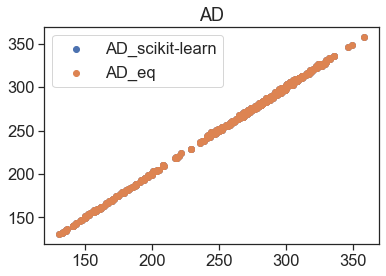

{'R2_test': 0.9995612072811877,
 'R2_train': 0.9995289235003847,
 'model_type': 'LinearRegression()',
 'rmse_test': 1.0696098625022255,
 'rmse_train': 1.1146573339301202,
 'wl': 'AD'}
0.38995820089831595


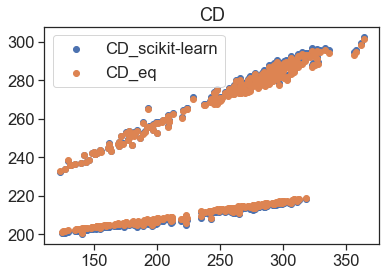

{'R2_test': 0.3856068080932701,
 'R2_train': 0.3745758169384237,
 'model_type': 'LinearRegression()',
 'rmse_test': 45.092422741525255,
 'rmse_train': 45.188074369393135,
 'wl': 'CD'}


In [19]:
sample_size = 1000

for wl in ("AD", "CD"):
    target = f"OZ{wl}"
    variables = [f"n{wl[0]}_m_n{wl[1]}_o_mu"]
    model = LinearRegression()

    # Get rid of NaN values
    df_sample = df_direct[[*variables, target]].dropna().sample(sample_size)
    X = df_sample[variables]
    y = df_sample[target]

    # Make a train/test split
    index_train, index_test = train_test_split(
        df_sample.index,
        test_size=0.5,
    )

    xtrain, ytrain = X.loc[index_train], y.loc[index_train]
    xtest, ytest = X.loc[index_test], y.loc[index_test]

    # Train the model
    model.fit(xtrain, ytrain)

    # Predictions for evaluation
    pred_train = model.predict(xtrain)
    pred_test = model.predict(xtest)

    param = eq.Parameter(distribution='normal', shape_parameter_A=0.0, shape_parameter_B=1.0, order=1)
    basis = eq.Basis('univariate')
    poly = eq.Poly(param, basis, method='least-squares', sampling_args={'sample-points':xtrain.to_numpy(), 'sample-outputs':ytrain.to_numpy()})
    poly.set_model()

    pred_train_eq = poly.get_polyfit(X.loc[index_train])
    pred_test_eq = poly.get_polyfit(X.loc[index_test])

    print(eq.datasets.score(ytest.to_numpy(), pred_test_eq))

    # How well did it do?
    result = {}
    result["wl"] = wl
    result["model_type"] = model.__repr__()
    result["R2_train"] = model.score(xtrain, ytrain)
    result["R2_test"] = model.score(xtest, ytest)
    result["rmse_train"] = mean_squared_error(
        y.loc[index_train], pred_train, squared=False
    )
    result["rmse_test"] = mean_squared_error(
        y.loc[index_test], pred_test, squared=False
    )

    # Plot 
    plt.scatter(ytrain, pred_train, label=wl+'_scikit-learn')
    plt.scatter(ytrain, pred_train_eq, label=wl+'_eq')
    plt.title(wl)
    plt.legend()
    plt.show()

    pprint(result)
# plt.legend()